# Analisis Exploratorio - Datos USB - mio
Fuentes de datos analizadas

* pd_academico
* pd_basico
* pd_movilidad
* pd_paoe
* pd_situacion


### Preparación del entorno

In [369]:
#Se importan las librerías a implementar
import pandas as pd
import psycopg2

### Definición de funciones

In [370]:
""" Función para calcular la edad
calcular_edad(fecha de nacimiento):
return edad"""

def calcular_edad(fecha_nacimiento):
    from datetime import date
    hoy = date.today()
    edad = int(hoy.year - fecha_nacimiento.year)
    
    return edad

### Conexión a fuentes de datos
Se muestra la configuración de la conexión a una base de datos Postgres local, con el fin de implementarse más adelante la conexión directa a la base de datos de la IES

In [371]:
# Variables globales
PSQL_HOST = "localhost"
PSQL_PORT = "5432"
PSQL_USER = "postgres"
PSQL_PASS = "****"
PSQL_DB = "ruav_usb"

connection_address = """
host=%s port=%s user=%s password=%s dbname=%s
"""% (PSQL_HOST, PSQL_PORT, PSQL_USER, PSQL_PASS, PSQL_DB)

connection = psycopg2.connect(connection_address)

Se muestra como sería la conexión directamente a un archivo CSV

In [ ]:
df_personales = pd.read_csv('datos_personales_v1.csv',';')

### Inicio de exploración de los datos

Inicio cargando en forma de dataset, mediante una consulta a la base de datos, toda la información que necesito de sus tablas

In [372]:
#Consulta para cargar todo el historial académico compartido
query_historial = "select * from historial_desempeno_materias;"
df_historial= pd.read_sql_query(query_historial,connection)

In [373]:
#Consulta para obtener los ID de aquellos estudiantes que finalizaron su programa exitosamente,Graduados
query_graduados = "select id_usb from graduados;"
id_graduados= (pd.read_sql_query(query_graduados,connection).id_usb).tolist() #se almacena como list para utilizar luego in

Se crea diccionario con id de estudiantes que han cursado los diferentes semestres del periodo comprendido en la data

In [374]:
anos = list(range(2009,2021,1)) #Años disposibles
periodos = list(range(1,3,1)) #Semestre 1 y 2
semestres = [] #Lista que contendrá los semestres, ejemplo 20191
matricula_tiempo = {} #Diccionario
for i in anos:
    for j in periodos:
        semestres.append(str(i)+str(j)) #Se crea la cadena de caracteres año+periodo
        if i == 2020:
            break

#Ciclo para poblado de diccionario
k = 0
for i in anos:
    for j in periodos:
        id_usb = ((df_historial[(df_historial.anho == str(i)) & (df_historial.periodo == str(j))][['id_usb']])['id_usb'].unique()).tolist()
        matricula_tiempo[semestres[k]] = id_usb
        if semestres[k] == '20201':
            break
        k = k+1

Se creará dataframe para identificar la permanencia de los estudiantes en el programa, dos faltas consecutivas serán consideradas como motivo de deserción, por lo que recibirán la etiqueta de Desertor. Los estudiantes matriculados en 20201 tendrán la etiqueta de Activo. Y quienes hayan finalizado su programa serán etiquetados como Graduado

In [375]:
#Dataframe binario donde 1 significa que el si se cursó un semestre determinado y 0 significa que no
permanencia = pd.DataFrame(columns=['id_usb','20091','20092','20101','20102','20111','20112','20121','20122','20131','20132','20141','20142','20151','20152','20161','20162','20171','20172','20181','20182','20191','20192','20201','Estado']
                    )
permanencia['id_usb'] = df_historial['id_usb'].unique()

#Se pobla el dataframe
k = 0
for i in range(permanencia.shape[0]):
    for j in matricula_tiempo.keys():
        if permanencia.loc[k,'id_usb'] in matricula_tiempo[j]:
            permanencia.loc[k,j] = 1
        else:
            permanencia.loc[k,j] = 0
    k = k + 1

In [376]:
#Se agregan etiquetas Activo y Graduado
for i in range(permanencia.shape[0]):
    if permanencia.loc[i,'20201'] == 1:
        permanencia.loc[i,'Estado'] = 'Activo'
    if permanencia.loc[i,'id_usb'] in id_graduados:
        permanencia.loc[i,'Estado'] = 'Graduado'

En búsqueda de los Desertores

In [377]:
#Se traen los id de estudiantes que no tienen ninguna categórica asignada
desertores = []
mask = permanencia['Estado'].isnull()
candidatos_desertores = permanencia[mask].reset_index(drop = True)

In [378]:
#Se buscan aquellos candidatos a desertores que cumplan con 2 semestres de inactividad consecutiva
for i in range(candidatos_desertores.shape[0]):
    k = -1
    periodo_inactivo = 0
    for j in range(candidatos_desertores.shape[1]):
        if permanencia.iloc[i,j] == 1:
            k = 1
            periodo_inactivo = 0
            continue
        elif candidatos_desertores.iloc[i,j] == 0 & k != -1:
            periodo_inactivo = periodo_inactivo + 1
            if periodo_inactivo == 2:
                desertores.append(candidatos_desertores.loc[i,'id_usb'])
                break
        else:
            continue

In [379]:
for i in desertores:
    index = permanencia['id_usb']==i
    permanencia.loc[index,'Estado'] = 'Desertor'

In [380]:
permanencia

,id_usb,20091,20092,20101,20102,20111,20112,20121,20122,20131,...,20161,20162,20171,20172,20181,20182,20191,20192,20201,Estado
0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,Desertor
1,2,0,0,0,0,0,0,0,1,1,...,1,1,1,0,0,0,0,0,0,Graduado
2,3,0,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,Graduado
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,Activo
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,1,0,0,Desertor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Activo
386,387,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,Activo
387,388,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,Activo
388,389,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Desertor


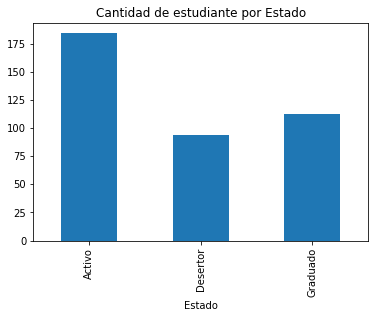

In [381]:
permanencia.groupby('Estado').count()["id_usb"].plot(kind='bar', title = 'Cantidad de estudiante por Estado')
#plt.title("Cantidad de estudiante por Estado")

### Se cálculos importantes
Cálculo de promedio acumulado para cada estudiante. Se añadirá una columna al dataset, llamada **nota_credito** y allí se almacenará el producto entre las columnas **creditos** y **calificacion**. Para posteriormente hallar la nota promedio según la cantidad de créditos vistos

In [ ]:
#Se halla la multiplicación entre las oclumnas creditos y calificacion, y se asigna a la nueva columna nota_credito
df_historial['nota_credito'] = df_historial['creditos']*df_historial['calificacion']

In [ ]:
#Se calcula el promedio acumulado de cada uno de los estudiantes y se añade al dataset permanencia
promedio_acumulado = []
for i in df_historial['id_usb'].unique():
    promedio_acumulado.append(round(df_historial[(df_historial['id_usb'] == i)]['nota_credito'].sum()/df_historial[(df_historial['id_usb'] == i)]['creditos'].sum(),2))
permanencia['Promedio_Acumulado'] = promedio_acumulado

Ahora se calculará la cantidad de materias vista por los estudiantes a lo largo de su estadía en la universidad y posteriormente se añade la variable cantidad_repeticiones (veces vista una materia),  esta  se añade pero se deja a consideración su uso, puesto que los planes de estudio no permiten distinguir algunas materias que son diferentes, como es el caso de las electivas en alguna línea

In [ ]:
permanencia['cantidad_materias'] = df_historial.groupby('id_usb')['materia'].nunique().tolist()

In [ ]:
lst = []
cantidad_repeticiones = []
for i in df_historial['id_usb'].unique():
    lst = (df_historial[df_historial['id_usb'] == i]['materia'].value_counts()).tolist()
    repeticiones = 0
    for j in lst:
        if j >= 2:
            repeticiones = repeticiones + j - 1
        else:
            continue
    cantidad_repeticiones.append(repeticiones)
permanencia['cantidad_repeticiones'] = cantidad_repeticiones

Finalmente se agregan los datos personales de cada estudiante, como son el género y el estado civil

In [ ]:
permanencia["Genero"] = df_personales['genero']
permanencia["Estado_Civil"] = df_personales["estado_civil"]

Se procede a la parte de codificación, donde cada variable categórica se pasa a numérica. Pero antes de esto, se separará el dataframe ***Permanencia*** entre los estudiantes que ya conocemos su estado: graduado o desertor, y los estudiantes que se encuentran actualmente ***Activos***

In [ ]:
permanencia_conocido = permanencia[permanencia['Estado'] != 'Activo']
permanencia_activos = permanencia[permanencia['Estado'] == 'Activo']

Codificación usando LabelEncoder

In [ ]:
encoder = LabelEncoder()

In [ ]:
permanencia_conocido["Estado"] = encoder.fit_transform(permanencia_conocido["Estado"])
permanencia_conocido["Genero"] = encoder.fit_transform(permanencia_conocido["Genero"])
permanencia_conocido["Estado_Civil"] = encoder.fit_transform(permanencia_conocido["Estado_Civil"])

In [ ]:
permanencia_activos["Estado"] = encoder.fit_transform(permanencia_activos["Estado"])
permanencia_activos["Genero"] = encoder.fit_transform(permanencia_activos["Genero"])
permanencia_activos["Estado_Civil"] = encoder.fit_transform(permanencia_activos["Estado_Civil"])

In [ ]:
permanencia_conocido.to_csv('final_train.csv')
permanencia_activos.to_csv('final_test.csv')